In [22]:
import dgl
from dgl.data import CiteseerGraphDataset, CoraGraphDataset, PubmedGraphDataset
from dgl import AddSelfLoop
from dgl.dataloading import GraphDataLoader
from torch.utils.data import DataLoader
from dgl.nn import EdgeGATConv, GraphConv
import torch.nn as nn
import torch
from tqdm import tqdm
from sklearn.metrics import f1_score

In [23]:
dataset = dgl.data.CSVDataset('../data/dataset')

Done loading data from cached files.


In [24]:
train_dataset, val_datasetloader = dgl.data.utils.split_dataset(dataset, shuffle=True, frac_list=[0.9, 0.1])

In [25]:
data_loader = GraphDataLoader(dataset, batch_size=32, shuffle=True)
train_loader = GraphDataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = GraphDataLoader(val_datasetloader, batch_size=32, shuffle=True)

In [26]:
graphs = dgl.unbatch(next(iter(data_loader))[0])
len(graphs)

32

In [27]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate)

In [28]:
next(iter(data_loader))[0]
dgl.batch([dataset[0][0], dataset[1][0]])

Graph(num_nodes=9, num_edges=12,
      ndata_schemes={'feat': Scheme(shape=(768,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(768,), dtype=torch.float32)})

In [29]:
import torch.nn.functional as F
g = next(iter(data_loader))[0]

# g = dgl.add_self_loop(g)
# print(dgl.unbatch(g))
print(g.ndata['feat'].shape)
layer1 = EdgeGATConv(768, 768, 15, 2, allow_zero_in_degree=True)
layer2 = EdgeGATConv(15*2, 768, 15, 2, allow_zero_in_degree=True)
# layer1 = GraphConv(768, 15, allow_zero_in_degree=True)
# layer2 = GraphConv(15, 2, allow_zero_in_degree=True)
lin_layer = nn.Linear(15 * 2, 1)
edge_feat = g.edata['feat']
node_feat = g.ndata['feat']
print(edge_feat.shape)
out1 = layer1(g, node_feat, edge_feat, get_attention=False)
print(out1.shape)
print(out1.view(g.ndata['feat'].shape[0], 30).shape)
out2 = F.relu(layer2(g, out1.view(g.ndata['feat'].shape[0], 30), edge_feat))
print(out2.shape)
out2 = out2.view(g.ndata['feat'].shape[0], 30)
print(out2.shape)
# with g.local_scope():
#     g.ndata['feat'] = out2
#     hg1 = dgl.readout_nodes(g, 'feat')
#     print(hg1.shape)
g.ndata['feat'] = out2
hg = dgl.mean_nodes(g, 'feat')
print(hg.shape)
# he = dgl.mean_edges(g, 'feat')
# print(he.shape)
out3 = lin_layer(hg)
print(out3.shape)

# out1 = F.relu(layer1(g, g.ndata['feat']))
# print(out1.shape)
# out2 = F.relu(layer2(g, out1))
# print(out2.shape)
# g.ndata['h'] = out2
# # dgl.unbatch(g)
# dgl.mean_nodes(g, 'h').shape

torch.Size([117, 768])
torch.Size([142, 768])
torch.Size([117, 2, 15])
torch.Size([117, 30])
torch.Size([117, 2, 15])
torch.Size([117, 30])
torch.Size([32, 30])
torch.Size([32, 1])


In [30]:
import dgl.nn.pytorch as dglnn
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_feats, edge_feats, out_feats, num_heads, dropout_prob=0.5):
        super(Classifier, self).__init__()
        self.in_feats = in_feats
        self.edge_feats = edge_feats
        self.out_feats = out_feats
        self.num_heads = num_heads

        # Two-layer GAT with skip connections
        self.conv1 = dglnn.EdgeGATConv(in_feats, edge_feats, out_feats, num_heads, allow_zero_in_degree=True)
        self.conv2 = dglnn.EdgeGATConv(out_feats * num_heads, edge_feats, out_feats, num_heads, allow_zero_in_degree=True)

        # Dropout layers for regularization
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)

        # Final classification layer
        self.classify = nn.Linear(out_feats * num_heads, 1)

    def forward(self, g, node_feat, edge_feat):
        # First GAT layer with skip connection
        h1 = F.relu(self.conv1(g, node_feat, edge_feat))
        h1 = h1.view(h1.shape[0], self.out_feats * self.num_heads)
        h1 = self.dropout1(h1)

        # Second GAT layer
        h2 = F.relu(self.conv2(g, h1, edge_feat))
        h2 = h2.view(h2.shape[0], self.out_feats * self.num_heads)
        h2 = self.dropout2(h2)

        # Use a skip connection to combine features from both layers
        h_combined = h1 + h2

        # Aggregate graph nodes into a graph-level feature vector
        with g.local_scope():
            g.ndata['feat'] = h_combined
            hg = dgl.mean_nodes(g, 'feat')
            return torch.sigmoid(self.classify(hg))
        

def f1_metric(logits, labels):
    preds = (logits > 0.5).float()
    return f1_score(labels.cpu().numpy(), preds.cpu().numpy())

 10%|█         | 1/10 [00:17<02:37, 17.46s/it]

Epoch 1/10, Train Loss: 0.2352, Val Loss: 0.2084, Val F1: 0.1270


 20%|██        | 2/10 [00:31<02:01, 15.23s/it]

Epoch 2/10, Train Loss: 0.2001, Val Loss: 0.1721, Val F1: 0.4260


 30%|███       | 3/10 [00:46<01:45, 15.09s/it]

Epoch 3/10, Train Loss: 0.1824, Val Loss: 0.1572, Val F1: 0.4778


 40%|████      | 4/10 [00:59<01:27, 14.50s/it]

Epoch 4/10, Train Loss: 0.1780, Val Loss: 0.1572, Val F1: 0.4639


 50%|█████     | 5/10 [01:13<01:11, 14.23s/it]

Epoch 5/10, Train Loss: 0.1761, Val Loss: 0.1559, Val F1: 0.4544


 60%|██████    | 6/10 [01:28<00:58, 14.60s/it]

Epoch 6/10, Train Loss: 0.1716, Val Loss: 0.1559, Val F1: 0.5458


 70%|███████   | 7/10 [01:43<00:44, 14.81s/it]

Epoch 7/10, Train Loss: 0.1715, Val Loss: 0.1572, Val F1: 0.4641


 80%|████████  | 8/10 [01:57<00:29, 14.54s/it]

Epoch 8/10, Train Loss: 0.1710, Val Loss: 0.1522, Val F1: 0.5025


 90%|█████████ | 9/10 [02:13<00:14, 14.84s/it]

Epoch 9/10, Train Loss: 0.1695, Val Loss: 0.1579, Val F1: 0.5115


100%|██████████| 10/10 [02:28<00:00, 14.89s/it]

Epoch 10/10, Train Loss: 0.1691, Val Loss: 0.1579, Val F1: 0.5306


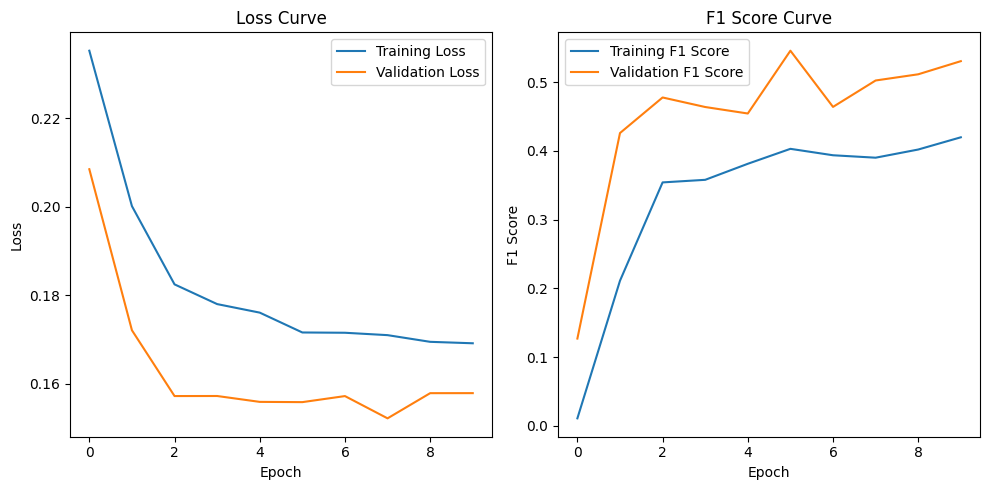

In [31]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Assuming you have defined f1_metric and train_loader/val_loader

# Function to plot training curve
def plot_training_curve(train_losses, val_losses, train_f1_scores, val_f1_scores):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1_scores, label='Training F1 Score')
    plt.plot(val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

in_feats_dim = 768
edge_feats_dim = 768
out_feats = 15
num_heads = 1

model = Classifier(in_feats_dim, edge_feats_dim, out_feats, num_heads)
opt = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

loss_func = nn.BCELoss()

best_val_loss = float('inf')
best_model = None

epoch_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    epoch_f1 = 0
    model.train()
    for i, (batched_graph, labels) in enumerate(train_loader):
        node_feats = batched_graph.ndata['feat']
        edge_feats = batched_graph.edata['feat']
        logits = model(batched_graph, node_feats, edge_feats)
        loss = loss_func(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()
        f1 = f1_metric(logits, labels)
        epoch_f1 += f1
    epoch_loss /= (i + 1)
    epoch_f1 /= (i + 1)
    epoch_losses.append(epoch_loss)
    train_f1_scores.append(epoch_f1)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_f1 = 0
    with torch.no_grad():
        for i, (batched_graph, labels) in enumerate(val_loader):
            node_feats = batched_graph.ndata['feat']
            edge_feats = batched_graph.edata['feat']
            logits = model(batched_graph, node_feats, edge_feats)
            loss = loss_func(logits, labels)
            val_loss += loss.item()
            f1 = f1_metric(logits, labels)
            val_f1 += f1

    val_loss /= (i + 1)
    val_losses.append(val_loss)
    val_f1 /= (i + 1)
    val_f1_scores.append(val_f1)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {epoch_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val F1: {val_f1:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()  # Extract the state dictionary

# After training completes, load the best model state dict
model.load_state_dict(best_model)

# Save the best model
torch.save(best_model, 'GAT_model_10epochs_new.pth')

# Plotting the training curve
plot_training_curve(epoch_losses, val_losses, train_f1_scores, val_f1_scores)

